In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

tickers = yf.Tickers('NVDA AAPL MSFT AMZN GOOG META TSLA AVGO BRK-B WMT JPM LLY')

# Download the price data
df_px = tickers.download(start="2022-01-01")

# Calculate the returns
df_ret = df_px['Close'].pct_change().iloc[1:]

# Download the market cap and total equity data
data = {}
for i in tickers.tickers:
    data[i] = {'Market Cap': tickers.tickers[i].fast_info['marketCap'],
                 'Total Equity': tickers.tickers[i].quarterly_balance_sheet.loc['Stockholders Equity'].iloc[0]}
df_data = pd.DataFrame(data).T

# Calculate the Price-to-Book ratio
df_data['Price to Book'] = df_data['Market Cap']/df_data['Total Equity']

# Download S&P index data
df_spx = yf.Tickers('^GSPC').download(start="2022-01-01")
df_spx_ret = df_spx[['Close']].pct_change().droplevel(level=1, axis=1)

[*********************100%***********************]  12 of 12 completed
[*********************100%***********************]  1 of 1 completed


# Fama-French Risk Factor Model

In [3]:
# Calculate the median of market cap
size_med = df_data['Market Cap'].median()

# Calculate the 30 and 70-percentiles of the price-to-book ratios
pb_low = df_data['Price to Book'].quantile(0.3)
pb_high = df_data['Price to Book'].quantile(0.7)

# Grouping the stocks into 6 subportfolios
BH = df_data[(df_data['Market Cap'] >= size_med) & 
             (df_data['Price to Book'] >= pb_high)]

BN = df_data[(df_data['Market Cap'] >= size_med) & 
             (df_data['Price to Book'] < pb_high) & 
             (df_data['Price to Book'] > pb_low)]

BL = df_data[(df_data['Market Cap'] >= size_med) & 
             (df_data['Price to Book'] <= pb_low)]

SH = df_data[(df_data['Market Cap'] < size_med) & 
             (df_data['Price to Book'] >= pb_high)]

SN = df_data[(df_data['Market Cap'] < size_med) & 
             (df_data['Price to Book'] < pb_high) & 
             (df_data['Price to Book'] > pb_low)]

SL = df_data[(df_data['Market Cap'] < size_med) & 
             (df_data['Price to Book'] <= pb_low)]

# Calculate subportfolio returns
portfolios = {}
idx = pd.IndexSlice

port_dict = {'BH': BH, 'BN': BN, 'BL': BL, 
             'SH': SH, 'SN': SN, 'SL': SL}

for k,v in port_dict.items():
    ret = df_px.loc[:, idx[:, v.index]]['Close'].pct_change()
    port = ret * v['Market Cap']/sum(v['Market Cap'])
    portfolios[k] = port.sum(axis=1)

# Calculate the factor returns and the difference between the subportfolio returns 
val_ret = (portfolios['SH'] + portfolios['BH'])/2 - (portfolios['SL'] + portfolios['BL'])/2
size_ret = (portfolios['SH'] + portfolios['SN'] + portfolios['SL'])/3 - (portfolios['BH'] + portfolios['BN'] + portfolios['BL'])/3

In [5]:
factors = ['Market', 'Size', 'Value']
# Set up factor returns dataset
ff_fac_ret = pd.DataFrame([df_spx_ret['Close'], size_ret, val_ret]).T.iloc[1:]

# Regress asset return against factor returns
reg_AAPL = LinearRegression().fit(ff_fac_ret, df_ret['AAPL'])

for i in range(len(factors)):
    print(factors[i], f'{reg_AAPL.coef_[i]:.2f}')

Market 1.04
Size -0.23
Value 0.16


# Barra Risk Factor Model

In [10]:
X = df_data[['Market Cap', 'Price to Book']]

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the data
# Convert the signs of the data to be consistent with the Fama-French size and value factors
X_std = -1*scaler.fit_transform(X)

# Cross-sectional regressions to calculate the factor returns
fac_ret = []

for t in range(len(df_ret)):
    y = df_ret.iloc[t]
    reg = LinearRegression().fit(X_std, y)
    fac_ret.append(reg.coef_)
    
df_fac_ret = pd.DataFrame(np.array(fac_ret), columns=X.columns)
df_fac_ret.index = df_ret.index

# Time-series regression to calculate the factor exposure of for the asset
ff_fac_ret = df_spx_ret[['Close']].merge(df_fac_ret, left_index=True, right_index=True)

# Using Apple stock as an example
reg_AAPL = LinearRegression().fit(ff_fac_ret, df_ret['AAPL'])

for i in range(len(factors)):
    print(factors[i], f'{reg_AAPL.coef_[i]:.2f}')

Market 1.23
Size -0.34
Value -0.27


Text(0.5, 1.0, 'Value Factor')

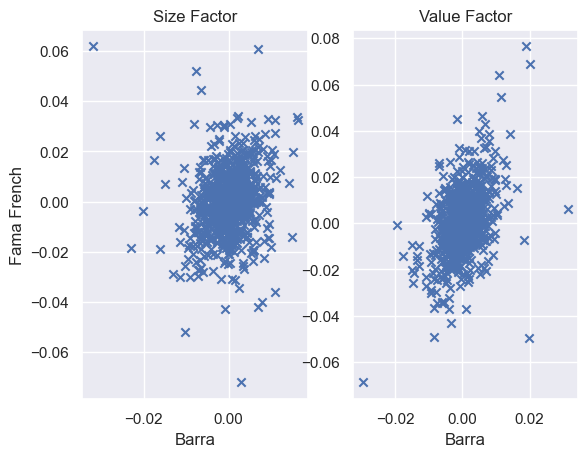

In [9]:
sns.set()
fig, ax = plt.subplots(1,2)
ax[0].scatter(df_fac_ret['Market Cap'], size_ret.iloc[1:], marker='x')
ax[0].set_xlabel('Barra')
ax[0].set_ylabel('Fama French')
ax[0].set_title('Size Factor')

ax[1].scatter(df_fac_ret['Price to Book'], val_ret.iloc[1:], marker='x')
ax[1].set_xlabel('Barra')
ax[1].set_title('Value Factor')

# Statistical Factor Model

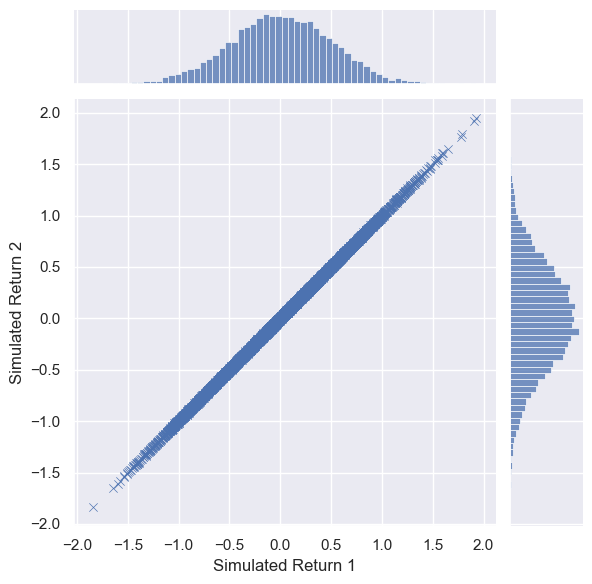

In [11]:
# Initialise parameters
n_simulation = 10000
sigma1  = 0.5; sigma2 = 0.5; rho = 0.9999
sigma_ex = np.array([[sigma1**2, rho*sigma1*sigma2],
                    [rho*sigma1*sigma2, sigma2**2]])

# Initialise matrix to store simulated returns
sim_r = np.full(shape=(n_simulation,2), fill_value=0.0)

# Cholesky Decomposition of covariance matrix
L = np.linalg.cholesky(sigma_ex)

# Set random seed
np.random.seed(100)

# Simulation
for m in range(n_simulation):
    Z = np.random.normal(size=(1,2))
    r = np.inner(L,Z).T
    sim_r[m] = r
    
df_r = pd.DataFrame(sim_r)

# Plot the simulated returns
chart = sns.jointplot(data=df_r, x=df_r[0], y=df_r[1], 
                      kind='scatter', marker='x')
chart.set_axis_labels('Simulated Return 1','Simulated Return 2')

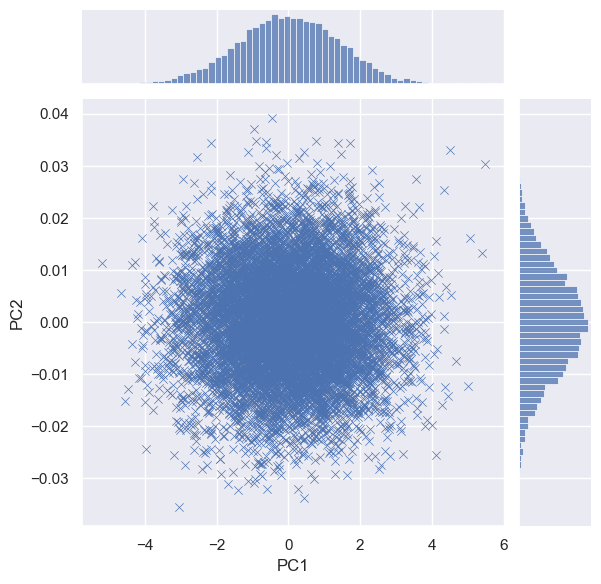

In [12]:
# Initialise PCA and standard scaler
pca = PCA(n_components=2)
scaler = StandardScaler()

# Standardise the returns
df_r_std = scaler.fit_transform(df_r)

# Transform the standardised returns using PCA
principalComponents = pca.fit_transform(df_r_std)
df_pca = pd.DataFrame(principalComponents)

# Plot the principal components
chart = sns.jointplot(data=df_pca, x=df_pca[0], y=df_pca[1], kind='scatter', marker='x')
chart.set_axis_labels('PC1','PC2')


Text(0, 0.5, 'Yield')

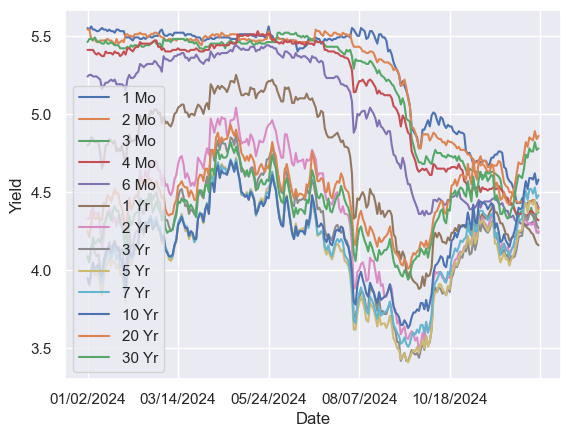

In [13]:
# Download and read the US Treasury data
df_rates = pd.read_csv('daily-treasury-rates.csv')
df_rates.set_index('Date', inplace=True)
df_rates.sort_index(inplace=True)

# Plot the data
fig = df_rates.plot()
fig.set_ylabel("Yield")

[8.31090519 4.57153624 0.128445  ]


Text(0.5, 1.0, 'PC3 (Curve)')

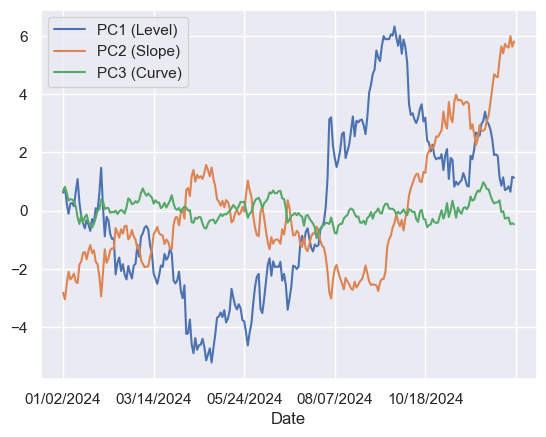

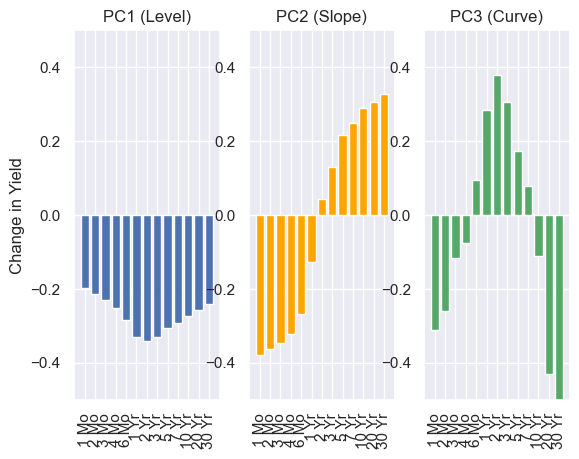

In [14]:
# Initialise PCA and standard scaler
pca = PCA(n_components=3)
scaler = StandardScaler()

# Apply scaling and PCA
df_rates_norm = scaler.fit_transform(df_rates)
principalComponents = pca.fit_transform(df_rates_norm)

df_pc = pd.DataFrame(data = principalComponents, 
                     columns = ['PC1 (Level)', 'PC2 (Slope)', 'PC3 (Curve)'],
                     index = df_rates.index
                    )

# Plot the principal components over time
df_pc[['PC1 (Level)', 'PC2 (Slope)', 'PC3 (Curve)']].plot()

# Extract the explained variance/eigenvalues
print(pca.fit(df_rates_norm).explained_variance_)

# Plot the principal components/eigenvectors
fig, ax = plt.subplots(1,3)
ax[0].set_ylabel('Change in Yield')
ax[0].set_ylim([-0.5, 0.5])
ax[0].bar(df_rates.columns,pca.fit(df_rates_norm).components_[0], color='b')
ax[0].tick_params("x", labelrotation=90)
ax[0].set_title('PC1 (Level)')

ax[1].set_ylim([-0.5, 0.5])
ax[1].bar(df_rates.columns,pca.fit(df_rates_norm).components_[1], color='orange')
ax[1].tick_params("x", labelrotation=90)
ax[1].set_title('PC2 (Slope)')

ax[2].set_ylim([-0.5, 0.5])
ax[2].bar(df_rates.columns,pca.fit(df_rates_norm).components_[2], color='g')
ax[2].tick_params("x", labelrotation=90)
ax[2].set_title('PC3 (Curve)')

[8.31090519 4.57153624 0.128445  ]


Text(0.5, 1.0, 'PC3 (Curve)')

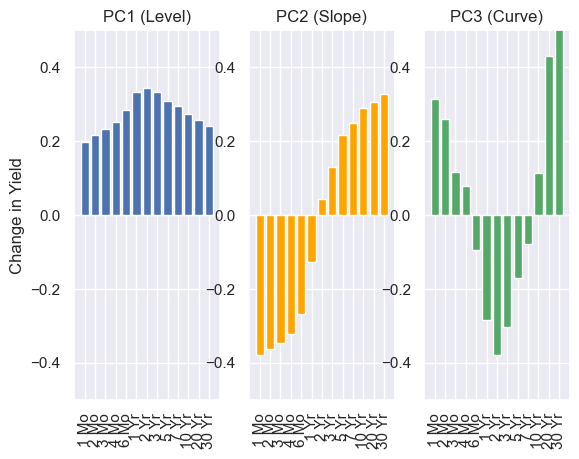

In [15]:
# Generate eigenvalues and eigenvectors from the covariance matrix
eigenvalues, eigenvectors = np.linalg.eig(np.cov(df_rates_norm.T))

# Print the first 3 eigenvalues
print(eigenvalues[:3])

# Plot the eigenvectors by maturity
fig, ax = plt.subplots(1,3)
ax[0].set_ylabel("Change in Yield")
ax[0].set_ylim([-0.5, 0.5])
ax[0].bar(df_rates.columns,eigenvectors[:,0], color='b')
ax[0].tick_params("x", labelrotation=90)
ax[0].set_title('PC1 (Level)')

ax[1].set_ylim([-0.5, 0.5])
ax[1].bar(df_rates.columns,eigenvectors[:,1], color='orange')
ax[1].tick_params("x", labelrotation=90)
ax[1].set_title('PC2 (Slope)')

ax[2].set_ylim([-0.5, 0.5])
ax[2].bar(df_rates.columns,eigenvectors[:,2], color='g')
ax[2].tick_params("x", labelrotation=90)
ax[2].set_title('PC3 (Curve)')

# VaR Estimation

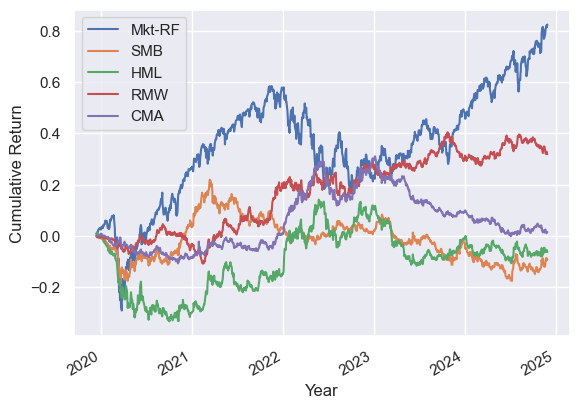

In [16]:
# Fama-French factor data from Professor French's website
df = pd.read_csv("F-F_Research_Data_5_Factors_2x3_daily.csv", skiprows=3, index_col=0)
df.index = pd.to_datetime(df.index, format="%Y%m%d")
df_ff_fac = df.iloc[:, :-1]/100

# Plot the factor returns
fig = ((df_ff_fac.iloc[len(df_ff_fac)-1250:,:5] + 1).cumprod()-1).plot()
fig.set_xlabel("Year")
fig.set_ylabel("Cumulative Return")

# Equal weighted portfolio
weights = [1/12]*12
wt = np.array(weights)[:, np.newaxis]
w = wt.T

# Calculate the portfolio return
ret_port = (df_ret * w).sum(axis=1)


In [17]:
# Generate the factor exposures of each position
factor_expo = {}
for i in df_ret:
    yt = df_ret[i]
    df_merged = pd.merge(df_ff_fac, yt, right_index=True, left_index=True)
    y = df_merged.iloc[:, -1:]
    X = df_merged.iloc[:, 0:-1]
    X = sm.add_constant(X)
    model = sm.OLS(y, X)
    est = model.fit()
    factor_expo[i] = est.params

In [18]:
# Calculate the portfolio factor weightings
df_factor_expo = pd.DataFrame(factor_expo)
df_weighted_fac = df_factor_expo * weights
df_wf = df_weighted_fac.sum(axis=1)

wft = np.array(df_wf[1:])[:, np.newaxis]
wf = wft.T

# Generate the factor covariance matrix
sigma = X.cov().iloc[1:, 1:]
sigma = np.array(sigma)

# Calculate the 95% VaR and Expected Shortfall with parametric method
port_vol = np.sqrt(wf @ sigma @ wft).flatten()
para_var = (port_vol * stats.norm.ppf(q=0.05) + ret_port.mean())
z_score = stats.norm.ppf(q=0.05)
para_es = ret_port.mean() - stats.norm.pdf(z_score)/0.05 * port_vol
print(f'VaR: {para_var[0]:.2%}, Expected Shortfall:{para_es[0]:.2%}')

VaR: -2.31%, Expected Shortfall:-2.92%
